## Introduction

### Business Context
The banking industry is very competitive, with many financial products aimed at meeting customer needs. One popular product is the term deposit, where customers invest their money for a fixed time and earn a guaranteed interest. Getting customers to subscribe to term deposits is not easy and needs carefully planned marketing campaigns.

Banks run marketing campaigns to attract customers to subscribe to term deposits. By using past data, machine learning can help predict which customers are more likely to subscribe. This allows banks to focus their efforts on the right customers and use their resources better.

### Problem Statement
Even with marketing campaigns, many customers do not subscribe to term deposits. This leads to a waste of resources and effort. The goal of this project is to predict if a customer will subscribe to a term deposit based on their profile and past interactions. This will help banks improve their marketing efficiency and get better results.

### Goals
- Create a model that predicts if a customer will subscribe to a term deposit.
- Identify which factors are most important for predicting subscription.

### Metric Evaluation
In this project, we will focus on **Precision** as the main metric.

- **Type I Error (False Positive):** This happens when the model predicts that a customer will subscribe, but they do not. This wastes marketing resources and increases costs.
- **Type II Error (False Negative):** This happens when the model predicts that a customer will not subscribe, but they actually do. This means losing potential revenue.

**Why Precision?** Since wasting marketing resources (Type I Error) is more expensive, Precision is the better choice. Precision helps ensure that the customers the model predicts as likely to subscribe are actually the right ones, saving time and money.

### Analytic Approach
- Study the dataset to understand its structure and patterns.
- Prepare and clean the data to make it ready for building the model.
- Create new features to improve the model's predictions.
- Test different models and evaluate them using **Precision** as the main metric.
- Improve the best model by tuning its parameters.
- Find out which factors are most important for predicting if a customer will subscribe.

## Initialization

In [1]:
## Import Libraries

# General
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Data Cleaning
import missingno

# Feature Engineering and Preprocessing
from scipy.stats import skew
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin


# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, recall_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Ignore Warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)



## Exploratory Data Understanding

### Dataset Overview
Let's load the dataset and display basic statistics to understand its structure.


In [2]:
# Load the dataset
file_path = 'data_bank_marketing_campaign.csv'
data = pd.read_csv(file_path)

# Display the first few rows
data.head()

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,yes
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no


### Attributes and Descriptions
| **Attribute** | **Description**                                      |
|---------------|------------------------------------------------------|
| `age`         | Age of the customer.                                |
| `job`         | Job type of the customer.                           |
| `balance`     | Customer's current account balance.                 |
| `housing`     | Whether the customer has a housing loan (yes/no).   |
| `loan`        | Whether the customer has a personal loan (yes/no).  |
| `contact`     | Communication type (e.g., telephone, cellular).     |
| `month`       | Month of the last contact.                          |
| `campaign`    | Number of contacts made during this campaign.       |
| `pdays`       | Days since the last contact in a previous campaign. |
| `poutcome`    | Outcome of the previous campaign (e.g., success).   |
| `deposit`     | Target variable: Subscribed to term deposit (yes/no).|

In [3]:
# Count and Datatype for each Column
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813 entries, 0 to 7812
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       7813 non-null   int64 
 1   job       7813 non-null   object
 2   balance   7813 non-null   int64 
 3   housing   7813 non-null   object
 4   loan      7813 non-null   object
 5   contact   7813 non-null   object
 6   month     7813 non-null   object
 7   campaign  7813 non-null   int64 
 8   pdays     7813 non-null   int64 
 9   poutcome  7813 non-null   object
 10  deposit   7813 non-null   object
dtypes: int64(4), object(7)
memory usage: 671.6+ KB


In [4]:
listItem = []
for col in data.columns :
    listItem.append([col, data[col].dtype, data[col].isna().sum(), round((data[col].isna().sum()/len(data[col])) * 100,2),
                    data[col].nunique(), list(data[col].drop_duplicates().head(4).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,age,int64,0,0.0,75,"[55, 39, 51, 38]"
1,job,object,0,0.0,12,"[admin., self-employed, services, housemaid]"
2,balance,int64,0,0.0,3153,"[1662, -3058, 3025, -87]"
3,housing,object,0,0.0,2,"[no, yes]"
4,loan,object,0,0.0,2,"[no, yes]"
5,contact,object,0,0.0,3,"[cellular, telephone, unknown]"
6,month,object,0,0.0,12,"[jun, apr, may, nov]"
7,campaign,int64,0,0.0,32,"[2, 3, 1, 4]"
8,pdays,int64,0,0.0,422,"[-1, 352, 21, 91]"
9,poutcome,object,0,0.0,4,"[unknown, other, failure, success]"


In [5]:
# Replace all 'unknown' values across all columns with NaN
data.replace('unknown', np.nan, inplace=True)

# Check for missing data after replacement
missing_data = data.isnull().sum()

# Display missing data counts
print(missing_data)


age            0
job           54
balance        0
housing        0
loan           0
contact     1639
month          0
campaign       0
pdays          0
poutcome    5819
deposit        0
dtype: int64


### Class Distribution Check
In this section, we analyze the distribution of the target variable (`deposit`) to check if the dataset is imbalanced..

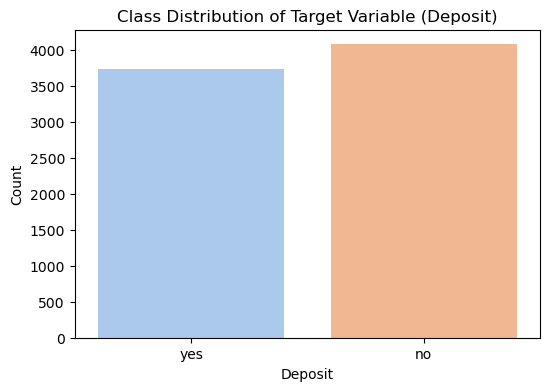

Class Distribution (in %):
deposit
no     52.233457
yes    47.766543
Name: proportion, dtype: float64


In [6]:
# Plot the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='deposit', palette='pastel')
plt.title('Class Distribution of Target Variable (Deposit)')
plt.xlabel('Deposit')
plt.ylabel('Count')
plt.show()

# Display percentages
target_distribution = data['deposit'].value_counts(normalize=True) * 100
print("Class Distribution (in %):")
print(target_distribution)

Data is not imbalanced. No action is required.

## Data Cleaning

### 1. Handling Missing Values

In [7]:
data.isna()

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
7808,False,False,False,False,False,False,False,False,False,True,False
7809,False,False,False,False,False,False,False,False,False,False,False
7810,False,True,False,False,False,False,False,False,False,True,False
7811,False,False,False,False,False,False,False,False,False,True,False


In [8]:
# Check for missing values
print("Missing Values Count Before Cleaning:")
print(data.isnull().sum())

Missing Values Count Before Cleaning:
age            0
job           54
balance        0
housing        0
loan           0
contact     1639
month          0
campaign       0
pdays          0
poutcome    5819
deposit        0
dtype: int64


The dataset contains missing values in the following categorical features:
- `job`
- `contact`
- `poutcome`

In [9]:
missing_indicators = data.isnull().astype(int)

# Add the target variable to the missing indicators DataFrame
missing_indicators['deposit'] = data['deposit'].apply(lambda x: 1 if x == 'yes' else 0)  # Ensure deposit is binary

# Compute correlations between missing indicators and the target variable
correlation_with_target = missing_indicators.corr()['deposit'].drop('deposit')

# Display correlations
print("Correlation of Missing Features with Target ('deposit'):")
print(correlation_with_target)
sorted_correlation = correlation_with_target.sort_values(ascending=False)
print("\nSorted Correlation of Missing Features with Target ('deposit'):")
print(sorted_correlation)


Correlation of Missing Features with Target ('deposit'):
age              NaN
job         0.000637
balance          NaN
housing          NaN
loan             NaN
contact    -0.264889
month            NaN
campaign         NaN
pdays            NaN
poutcome   -0.237757
Name: deposit, dtype: float64

Sorted Correlation of Missing Features with Target ('deposit'):
job         0.000637
poutcome   -0.237757
contact    -0.264889
age              NaN
balance          NaN
housing          NaN
loan             NaN
month            NaN
campaign         NaN
pdays            NaN
Name: deposit, dtype: float64


To address the missing values in the dataset, we apply different strategies tailored to each feature's context and importance:

1. **`job` Feature:**
   - Missing values in the `job` column are replaced using the **most frequent (mode)** value. 
   - This ensures the structure of the data remains intact by filling in the most common category, minimizing bias.

2. **`contact` and `poutcome` Features:**
   - Missing values in the `contact` and `poutcome` columns are replaced with placeholder categories: `"unknown_contact"` and `"unknown_outcome"` to preserve the missingness as a potential predictive signal.


In [10]:
categorical_features = ['job', 'contact', 'poutcome']

# Handling missing values for 'job' using the most frequent value
job_imputer = SimpleImputer(strategy='most_frequent')
data['job'] = job_imputer.fit_transform(data[['job']]).ravel()  # Use ravel() to flatten the 2D array

# Handling missing values for 'contact' by replacing with a new category
data['contact'] = data['contact'].fillna('unknown_contact')

# Handling missing values for 'poutcome' using the most frequent value
poutcome_imputer = SimpleImputer(strategy='most_frequent')
data['poutcome'] = poutcome_imputer.fit_transform(data[['poutcome']]).ravel()  # Use ravel() to flatten the 2D array

# Verify
print("Remaining Missing Values After Handling:")
print(data.isnull().sum())


Remaining Missing Values After Handling:
age         0
job         0
balance     0
housing     0
loan        0
contact     0
month       0
campaign    0
pdays       0
poutcome    0
deposit     0
dtype: int64


### 2. Handling Duplicates

In [11]:
# Check for duplicates in the entire dataset
duplicates = data.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

Number of duplicate rows: 8


In [12]:
# View the actual duplicate rows
duplicate_rows = data[data.duplicated()]
print(duplicate_rows)


      age          job  balance housing loan          contact month  campaign  \
2944   40  blue-collar        0     yes   no  unknown_contact   may         2   
4368   60   management        0      no   no         cellular   aug         3   
4874   41   management        0      no   no         cellular   aug         2   
5326   44  blue-collar        0     yes   no         cellular   jul         1   
5609   39   technician        0     yes   no  unknown_contact   may         1   
5681   38   technician        0      no   no         cellular   aug         2   
5905   34   management        0      no   no         cellular   aug         2   
7077   30  blue-collar      239     yes   no  unknown_contact   may         1   

      pdays poutcome deposit  
2944     -1  failure      no  
4368     -1  failure     yes  
4874     -1  failure      no  
5326     -1  failure      no  
5609     -1  failure      no  
5681     -1  failure      no  
5905     -1  failure      no  
7077     -1  failure  

### 3. Handling Outliers
Calculate skew, identify outliers in numerical features using the IQR method, and  visualize boxplot.


In [13]:
data['campaign'].value_counts()

campaign
1     3354
2     2108
3      922
4      548
5      256
6      196
7      103
8       89
9       47
10      41
11      28
13      23
12      20
14      10
17       9
15       8
16       7
18       7
21       5
20       4
24       4
19       4
30       4
23       3
22       3
25       2
26       2
29       2
63       1
33       1
28       1
43       1
Name: count, dtype: int64

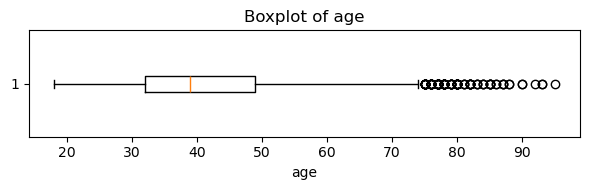

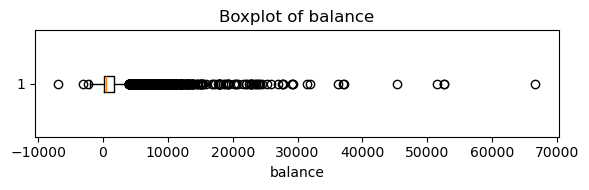

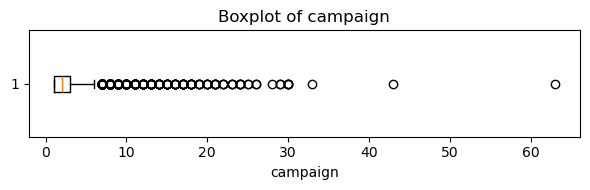

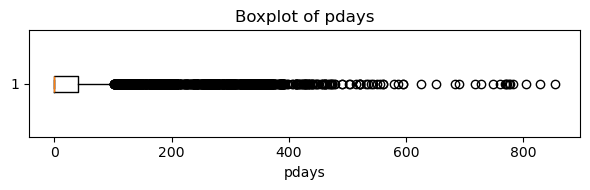

    Feature  Skewness  Outliers Count
0       age  0.867620             121
1   balance  6.760662             736
2  campaign  5.538156             429
3     pdays  2.411313            1454


In [14]:
# List of numerical features in the dataset
numerical_features = ['age', 'balance', 'campaign', 'pdays']

# Analyze numerical features
def analyze_numerical_features(data, numerical_features):
    results = []
    for feature in numerical_features:
        if feature in data.columns:  # Check if the feature exists in the DataFrame
            # Calculate skewness
            skewness = data[feature].skew()

            # Calculate IQR and outliers
            Q1 = data[feature].quantile(0.25)
            Q3 = data[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers_count = ((data[feature] < lower_bound) | (data[feature] > upper_bound)).sum()

            # Append results to the list
            results.append({
                'Feature': feature,
                'Skewness': skewness,
                'Outliers Count': outliers_count
            })

            # Visualize boxplot
            plt.figure(figsize=(6, 2))
            plt.boxplot(data[feature], vert=False)
            plt.title(f'Boxplot of {feature}')
            plt.xlabel(feature)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Feature {feature} not found in the dataset.")
    
    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Analyze the numerical features and store results
results_df = analyze_numerical_features(data, numerical_features)

# Display the results 
print(results_df)

1. **Age**
- **Method**: Create new features (using binning method) to represent later, ignore for now.
- **Reasoning**: Age can be more meaningful and interpretable when segmented into categories (e.g., Youth, Adult, Middle-Aged, Senior).

2. **Balance**
- **Method**: Removed extreme outliers by capping values above the 99th percentile and applied a cube root transformation to handle skewness and negative values.
- **Reasoning**: Balance includes valid negative values, and extreme outliers could disproportionately influence the model. The cube root transformation compresses extreme values symmetrically for both tails and can handle negative values.

3. **Campaign**
- **Method**: Removed extreme outliers by capping values above the 99th percentile and applied a square root transformation to normalize the distribution.
- **Reasoning**: Extreme campaign counts are rare and likely anomalies, distorting the distribution. Capping outliers ensures these values don't dominate the analysis, and the square root transformation effectively reduces moderate skewness while preserving relationships.

4. **Pdays**
- **Method**: Create new features (using binning method) to represent later, ignore for now.
- **Reasoning**: Most data points have a value of `-1`, indicating no previous contact. A binning approach will better represent the recency of contact in distinct categories for analysis and modeling.


Total data points removed: 156
Percentage of data points removed: 2.00%
Remaining data points: 7657


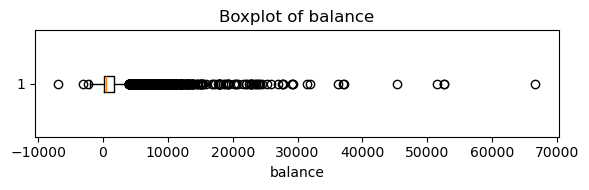

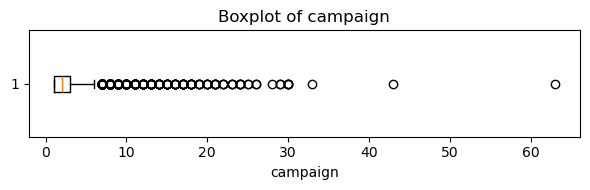

    Feature  Skewness  Outliers Count
0   balance  6.760662             736
1  campaign  5.538156             429


In [15]:
# Remove extreme outliers
# Initial count of data points
initial_count = data.shape[0]

# Define percentile thresholds
balance_99th = data['balance'].quantile(0.99)
campaign_95th = data['campaign'].quantile(0.99)

# Filter out outliers
data_filtered = data[(data['balance'] <= balance_99th) & (data['campaign'] <= campaign_95th)]

# Calculate removed data points
removed_data_points = initial_count - data_filtered.shape[0]
removed_percentage = (removed_data_points / initial_count) * 100

# Print results
print(f"Total data points removed: {removed_data_points}")
print(f"Percentage of data points removed: {removed_percentage:.2f}%")

# Remaining dataset size
print(f"Remaining data points: {data_filtered.shape[0]}")

# Analyze the numerical features and store results
results_df = analyze_numerical_features(data, ['balance','campaign'])

# Display the results DataFrame
print(results_df)


In [16]:
# Transform balance using cube root (handles negatives)
data['balance'] = np.cbrt(data['balance'])

# Transform campaign using square root
data['campaign'] = np.sqrt(data['campaign'])

# Validate skewness
from scipy.stats import skew
balance_skew = skew(data['balance'])
campaign_skew = skew(data['campaign'])

print(f"Balance Skewness After Cube Root: {balance_skew}")
print(f"Campaign Skewness After Square Root: {campaign_skew}")


Balance Skewness After Cube Root: -0.08693260144516272
Campaign Skewness After Square Root: 2.243282195805621


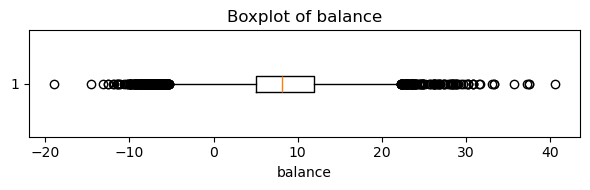

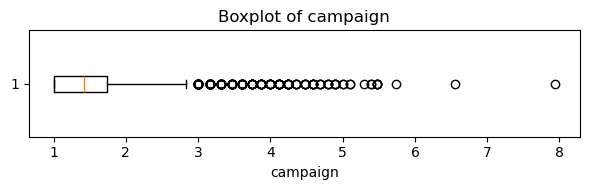

    Feature  Skewness  Outliers Count
0   balance -0.086949             445
1  campaign  2.243713             237


In [17]:
# Analyze the numerical features and store results
results_df = analyze_numerical_features(data, ['balance','campaign'])

# Display the results DataFrame
print(results_df)

### 4. Fixing Datatypes

In [18]:
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813 entries, 0 to 7812
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       7813 non-null   int64  
 1   job       7813 non-null   object 
 2   balance   7813 non-null   float64
 3   housing   7813 non-null   object 
 4   loan      7813 non-null   object 
 5   contact   7813 non-null   object 
 6   month     7813 non-null   object 
 7   campaign  7813 non-null   float64
 8   pdays     7813 non-null   int64  
 9   poutcome  7813 non-null   object 
 10  deposit   7813 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 671.6+ KB
None


,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin.,11.845235,no,no,cellular,jun,1.414214,-1,failure,yes
1,39,self-employed,-14.514848,yes,yes,cellular,apr,1.732051,-1,failure,yes
2,51,admin.,14.462447,no,no,cellular,may,1.000000,352,other,yes
3,38,services,-4.431048,yes,no,cellular,may,1.000000,-1,failure,no
4,36,housemaid,5.896369,yes,no,telephone,nov,2.000000,-1,failure,no


| **Column**   | **Current Dtype** | **Expected Dtype** | **Reasoning for Conversion**                                      |
|--------------|--------------------|---------------------|--------------------------------------------------------------------|
| `job`        | `object`          | `category`         | `Job` has a limited set of categories, so using `category` optimizes memory usage. |
| `housing`    | `object`          | `boolean`          | `Housing` is a binary variable (`yes`/`no`), so mapping to boolean is more intuitive. |
| `loan`       | `object`          | `boolean`          | `Loan` is a binary variable (`yes`/`no`), so mapping to boolean simplifies analysis. |
| `contact`    | `object`          | `category`         | `Contact` has a limited set of categories, making `category` more efficient and appropriate. |
| `month`    | `object`          | `category`         | `Month` has a limited set of categories, making `category` more efficient and appropriate. |
| `poutcome`   | `object`          | `category`         | `Poutcome` represents categorical outcomes, so `category` is the correct datatype. |
| `deposit`    | `object`          | `boolean`          | `Deposit` is a binary target variable (`yes`/`no`), so mapping to boolean is suitable for modeling. |

In [19]:
# Convert to appropriate data types
data['age'] = data['age'].astype('int64')  # Convert age to integer
data['job'] = data['job'].astype('category')  # Convert job to category
data['housing'] = data['housing'].map({'yes': True, 'no': False})  # Convert housing to boolean
data['loan'] = data['loan'].map({'yes': True, 'no': False})  # Convert loan to boolean
data['contact'] = data['contact'].astype('category')  # Convert contact to category
data['month'] = data['month'].astype('category')  # Convert month to category
data['poutcome'] = data['poutcome'].astype('category')  # Convert poutcome to category
data['deposit'] = data['deposit'].map({'yes': True, 'no': False})  # Convert deposit to boolean

# Check the updated data types
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813 entries, 0 to 7812
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       7813 non-null   int64   
 1   job       7813 non-null   category
 2   balance   7813 non-null   float64 
 3   housing   7813 non-null   bool    
 4   loan      7813 non-null   bool    
 5   contact   7813 non-null   category
 6   month     7813 non-null   category
 7   campaign  7813 non-null   float64 
 8   pdays     7813 non-null   int64   
 9   poutcome  7813 non-null   category
 10  deposit   7813 non-null   bool    
dtypes: bool(3), category(4), float64(2), int64(2)
memory usage: 298.7 KB
None
   age            job    balance  housing   loan    contact month  campaign  \
0   55         admin.  11.845235    False  False   cellular   jun  1.414214   
1   39  self-employed -14.514848     True   True   cellular   apr  1.732051   
2   51         admin.  14.462447    False  False   cellul

## Feature Engineering

1. `pdays_binned`
- **Reasoning:** The recency of the last contact may influence customer behavior. Customers contacted recently might exhibit different subscription behaviors compared to those contacted long ago or not at all.
- **Logic:** Categorizes the `pdays` feature into fixed bins based on domain knowledge:
  - **0:** `pdays == -1`
    - Represents cases where there was no prior contact.
  - **1:** `-1 < pdays <= 7`
    - Represents very recent (contacts that occurred within the past week).
  - **2:** `7 < pdays <= 30`
    - Represents moderate recency (contacts that occurred between one week and one month ago).
  - **3:** `pdays > 30`
    - Represents long-past contact (contacts that occurred more than a month ago).
  
2. `age_group`
- **Reasoning:** Age groups may correlate with financial behavior and preferences, providing meaningful segmentation for marketing strategies.
- **Logic:** Divides the `age` feature into the following bins:
  - **0:** Youth (ages 0–25).
  - **1:** Adult (ages 26–40).
  - **2:** Middle-Aged (ages 41–60).
  - **3:** Senior (ages 61 and above).

In [20]:
# Define bins explicitly for correct handling of -1
Q1_pdays = data['pdays'][data['pdays'] > -1].quantile(0.25)
Q3_pdays = data['pdays'][data['pdays'] > -1].quantile(0.75)

# Define fixed bins for pdays
data['pdays_binned'] = pd.cut(
    data['pdays'],
    bins=[-2, -0.5, 7, 30, float('inf')],  # Use domain-based or manual bin edges
    labels=[0, 1, 2, 3],
    include_lowest=True
)

# Bin age into categories
data['age_group'] = pd.cut(
    data['age'],
    bins=[0, 25, 40, 60, float('inf')],
    labels=[0, 1, 2, 3],
    include_lowest=True
)

# Verify the updated features
print(data[['age', 'age_group', 'pdays_binned']].head())

# Frequency counts for pdays_binned
print(data['pdays_binned'].value_counts())


   age age_group pdays_binned
0   55         2            0
1   39         1            0
2   51         2            3
3   38         1            0
4   36         1            0
pdays_binned
0    5817
3    1963
2      22
1      11
Name: count, dtype: int64


In [21]:
data.head()

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit,pdays_binned,age_group
0,55,admin.,11.845235,False,False,cellular,jun,1.414214,-1,failure,True,0,2
1,39,self-employed,-14.514848,True,True,cellular,apr,1.732051,-1,failure,True,0,1
2,51,admin.,14.462447,False,False,cellular,may,1.000000,352,other,True,3,2
3,38,services,-4.431048,True,False,cellular,may,1.000000,-1,failure,False,0,1
4,36,housemaid,5.896369,True,False,telephone,nov,2.000000,-1,failure,False,0,1


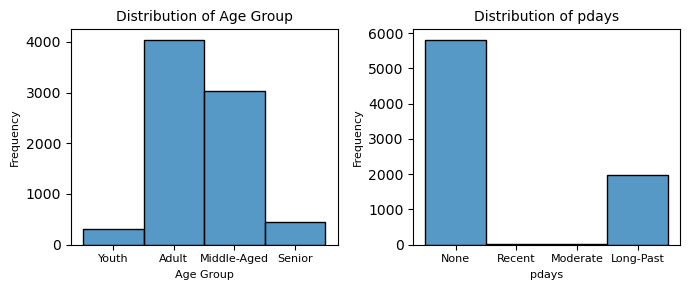

        Feature  Skewness
0     Age Group  0.321133
1  Pdays Binned  1.132073


In [22]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

# Plot age_group 
sns.histplot(data['age_group'], bins=4, kde=False, discrete=True, ax=axes[0])
axes[0].set_title('Distribution of Age Group', fontsize=10)
axes[0].set_xlabel('Age Group', fontsize=8)
axes[0].set_ylabel('Frequency', fontsize=8)
axes[0].set_xticks([0, 1, 2, 3])
axes[0].set_xticklabels(['Youth', 'Adult', 'Middle-Aged', 'Senior'], fontsize=8)

# Plot pdays_binned 
sns.histplot(data['pdays_binned'], bins=4, kde=False, discrete=True, ax=axes[1])
axes[1].set_title('Distribution of pdays', fontsize=10)
axes[1].set_xlabel('pdays', fontsize=8)
axes[1].set_ylabel('Frequency', fontsize=8)
axes[1].set_xticks([0, 1, 2, 3])
axes[1].set_xticklabels(['None', 'Recent', 'Moderate', 'Long-Past'], fontsize=8)

plt.tight_layout()
plt.show()

# Calculate skewness for both distributions
from pandas import DataFrame
from scipy.stats import skew

skew_table = DataFrame({
    "Feature": ["Age Group", "Pdays Binned"],
    "Skewness": [
        skew(data['age_group'].dropna()),
        skew(data['pdays_binned'].dropna())
    ]
})
print(skew_table)

The skew and has improved for both `age` and `pdays` after being represented with a new feature.

In [23]:
data.to_csv('cleaned_data.csv', index=False)

### Feature Selection

In [24]:
# Create a copy for analysis
data_encoded = data.copy()

# Binary Encoding
data_encoded['housing'] = data_encoded['housing'].astype(int)
data_encoded['loan'] = data_encoded['loan'].astype(int)

# Ordinal Encoding
data_encoded['pdays_binned'] = data_encoded['pdays_binned'].astype(int)
data_encoded['age_group'] = data_encoded['age_group'].astype(int)

# One-Hot Encoding for Nominal Variables
data_encoded = pd.get_dummies(data_encoded, columns=['job', 'contact', 'month', 'poutcome'], drop_first=True)
# data_encoded = data_encoded.drop(columns=['job'])

# Verify the transformed dataset
data_encoded.head()


,age,balance,housing,loan,campaign,pdays,deposit,pdays_binned,age_group,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,contact_telephone,contact_unknown_contact,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success
0,55,11.845235,0,0,1.414214,-1,True,0,2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,39,-14.514848,1,1,1.732051,-1,True,0,1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,51,14.462447,0,0,1.000000,352,True,3,2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
3,38,-4.431048,1,0,1.000000,-1,False,0,1,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
4,36,5.896369,1,0,2.000000,-1,False,0,1,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False


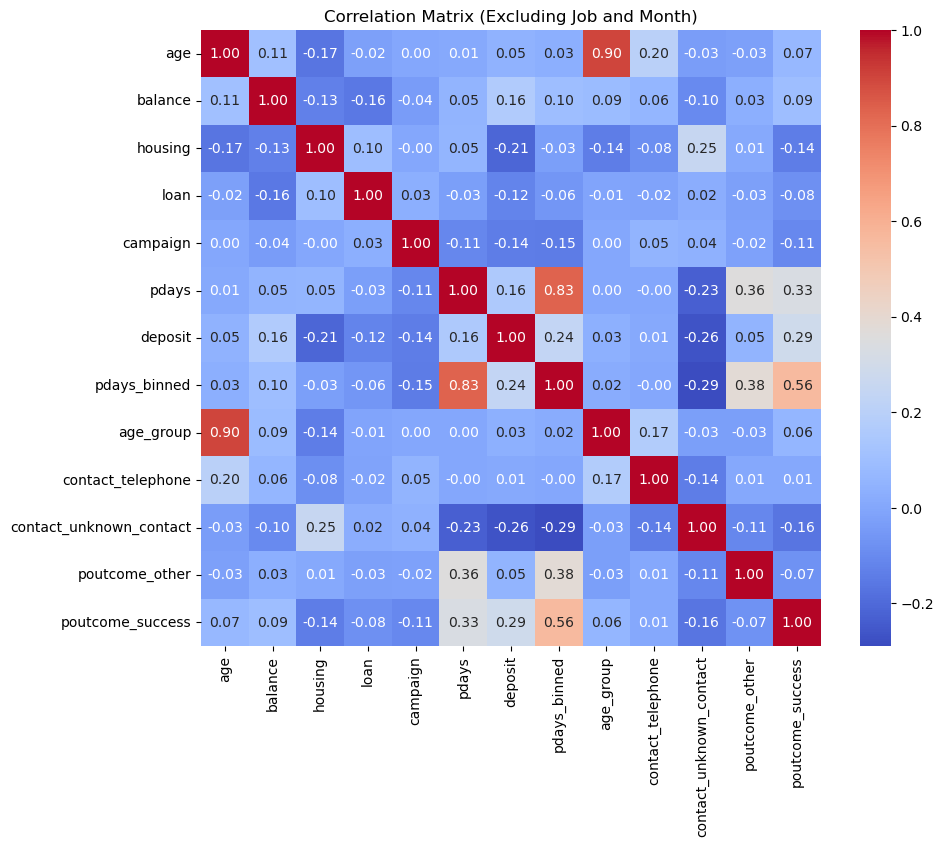

Highly Correlated Feature Pairs: [('age', 'age_group'), ('pdays', 'pdays_binned'), ('pdays_binned', 'pdays'), ('age_group', 'age')]


In [25]:
# Multicollinearity Analysis
# Drop job and month related columns
columns_to_exclude = [col for col in data_encoded.columns if 'job_' in col or 'month_' in col]
data_filtered = data_encoded.drop(columns=columns_to_exclude)

# Compute the correlation matrix for the remaining features
correlation_matrix = data_filtered.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Excluding Job and Month)')
plt.show()

# Identify highly correlated feature pairs
high_corr_pairs = [
    (col1, col2)
    for col1 in correlation_matrix.columns
    for col2 in correlation_matrix.columns
    if col1 != col2 and abs(correlation_matrix[col1][col2]) > 0.8
]
print("Highly Correlated Feature Pairs:", high_corr_pairs)

Due to the very high correlation between `age` and `age_group`, one of them needs to be dropped to avoid redundancy.

In [26]:
corr_matrix = data_encoded.corr()
print(corr_matrix['deposit'].sort_values(ascending=False))

deposit                    1.000000
poutcome_success           0.287344
pdays_binned               0.239273
balance                    0.164674
pdays                      0.157947
month_oct                  0.145165
month_mar                  0.133276
month_sep                  0.121019
job_retired                0.108153
job_student                0.096680
month_dec                  0.075915
poutcome_other             0.049839
month_feb                  0.046636
age                        0.046585
job_unemployed             0.040935
job_management             0.035125
age_group                  0.034516
contact_telephone          0.009241
job_self-employed         -0.009300
month_jan                 -0.014387
job_technician            -0.014948
month_aug                 -0.016499
month_jun                 -0.019974
month_nov                 -0.021999
job_housemaid             -0.026851
job_entrepreneur          -0.028040
job_services              -0.050104
month_jul                 -0

#### **Features of Interest**
- **`job`**

    The `job` feature includes several low-frequency categories with minimal predictive power. Grouping rare jobs (<5%) into "Other" is decided because:
    
    - **Dimensionality Reduction**: It reduces the number of one-hot encoded columns, making the dataset easier to work with.
    - **Preserve Information**: This approach retains the collective influence of rare jobs without adding unnecessary complexity.
    - **Focus on Impactful Jobs**: It allows the model to prioritize high-impact categories like `retired` and `student`, which have stronger correlations with `deposit`.

#### Dropping features
- `age_group` will be dropped due to the redundancy with `age`, which have a higher correlation to the  target value.
- `pdays` and `job` are dropped to avoid redundancy.
Dropping will be done in the preprocessing pipeline to ensure reproducibility.
For the same reason, the new features `age_group` and `pdays_binned` will dropped here and created later.

## Data Preprocessing

In this section, we preprocess the dataset to ensure it is ready for machine learning modeling. This involves encoding categorical features, scaling numerical features, transforming or creating new features where necessary, and applying the feature engineering and feature selection strategies decided in the previous sections. These steps are incorporated into a pipeline for consistency and reproducibility.

### Preprocessing Steps

| **Step**                  | **Feature(s) Affected**               | **Action**                                                                                             | **Reasoning**                                                                                   |
|---------------------------|----------------------------------------|--------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
| **Binning**               | `pdays`                        | Transformed into `pdays_binned` category.                                             | Captures meaningful groupings for contact recency (`0: No Contact`, `1: Very Recent`, `2: Moderate`, `3: Long-Past`) to improve interpretability and predictive power. |
| **Rare Category Grouping** | `job`                                | Grouped rare job categories (<5% frequency) into an "Other" category.                                  | Reduces dimensionality while retaining the collective signal of rare categories.                |
| **Ordinal Transformation**| `pdays_binned`           | Converted ordinal categories into numerical values (`0, 1, 2, 3`).                                      | Reflects natural order in features like contact recency and age group for better interpretability. |
| **One-Hot Encoding**       | `job`, `contact`, `month`, `poutcome`| Converted categorical values into binary columns using one-hot encoding.                               | Ensures the model can interpret categorical variables without assuming any ordinal relationship. |
| **Binary Encoding**        | `housing`, `loan`                    | Converted `True/False` to `0/1`.                                                                       | Simplifies boolean features into numerical format for compatibility with machine learning models.|
| **Scaling**                | `balance`, `campaign`                | Standardized these numerical features using `StandardScaler`.                                          | Normalizes numerical features to ensure they are on a similar scale for modeling.               |
| **Feature Selection**      | `age`, `pdays`                       | Dropped redundant features that were highly correlated with engineered features (`age_group`, `pdays_binned`). | Simplifies the dataset, reduces noise, and prevents multicollinearity.                          |
| **Pipeline Integration**   | All features                         | Combined transformations and feature engineering into a preprocessing pipeline.                        | Streamlines the workflow, ensuring consistent transformations during training and testing.       |

In [27]:
# Split data into features and target
data = data.drop(columns=['pdays_binned','age_group'], errors='ignore')
X = data.drop(columns=['deposit'])
y = data['deposit']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<!-- 
# Binning for age and pdays
def bin_features(df, feature_name, bins, labels, new_feature_name=None):
    # Use a default name for the new feature if not specified
    if new_feature_name is None:
        new_feature_name = f'{feature_name}_binned'
    
    # Apply binning
    df[new_feature_name] = pd.cut(
        df[feature_name],
        bins=bins,
        labels=labels,
        include_lowest=True
    ).astype(int)
    return df


# Define binning rules
# Youth, Adult, Middle-Aged, Senior
age_bins = [0, 25, 40, 60, float('inf')]
age_labels = [0, 1, 2, 3]

# None, Recent, Moderate, Long-Past
pdays_bins = [-2, -0.5, 7, 30, float('inf')]
pdays_labels = [0, 1, 2, 3]

# Binning for training data
X_train = bin_features(X_train, 'age', age_bins, age_labels, new_feature_name='age_group')
X_train = bin_features(X_train, 'pdays', pdays_bins, pdays_labels)


# Binning for test data
X_test = bin_features(X_test, 'age', age_bins, age_labels, new_feature_name='age_group')
X_test = bin_features(X_test, 'pdays', pdays_bins, pdays_labels) -->

In [28]:
# Function to preprocess binary and ordinal features
binary_features = ['housing', 'loan']
ordinal_features=['pdays_binned']

def preprocess_features(df):
    # Binning for ordinal features
    # age_bins = [0, 25, 40, 60, float('inf')]
    # age_labels = [0, 1, 2, 3]

    pdays_bins = [-2, -0.5, 7, 30, float('inf')]
    pdays_labels = [0, 1, 2, 3]

    # Apply binning
    # df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, include_lowest=True).astype(int)
    df['pdays_binned'] = pd.cut(df['pdays'], bins=pdays_bins, labels=pdays_labels, include_lowest=True).astype(int)

    # Convert binary features to integers
    for col in binary_features:
        df[col] = df[col].apply(lambda x: 1 if x == 'yes' else 0)

    # Drop redundant features
    df = df.drop(columns=['pdays'], errors='ignore')

    return df

# Preprocess training and test data
X_train = preprocess_features(X_train)
X_test = preprocess_features(X_test)

# Rare category grouping for job
def group_rare_categories_train(X_train, col, threshold=0.05):
    """
    Fit rare category grouping for training data.
    """
    # Calculate category frequencies
    freq = X_train[col].value_counts(normalize=True)
    # Identify frequent categories
    frequent_categories = freq[freq >= threshold].index
    return frequent_categories

def apply_rare_category_grouping(X, col, frequent_categories):
    """
    Apply the rare category grouping rules to the test set.
    """
    X[col] = X[col].apply(lambda x: x if x in frequent_categories else 'Other')
    return X

# Ensure categories in training and test sets are consistent
assert set(X_train['job'].unique()) == set(X_test['job'].unique())

# Collect all categories from training set
job_categories = X_train['job'].unique()

# Group rare categories in training data
frequent_jobs = group_rare_categories_train(X_train, 'job', threshold=0.05)
X_train = apply_rare_category_grouping(X_train, 'job', frequent_jobs)

# Apply the same grouping rules to test data
X_test = apply_rare_category_grouping(X_test, 'job', frequent_jobs)

# Verify updated features
print("Updated training data head:")
print(X_train[['pdays_binned', 'job']].head())

# Encode target variable and other boolean columns
y_train = y_train.astype(int)
y_test = y_test.astype(int)

Updated training data head:
      pdays_binned          job
1158             0        Other
4680             3   technician
3731             0       admin.
6141             0  blue-collar
4266             0        Other


In [29]:
# Feature groups after preprocessing
# numerical_features = ['balance', 'campaign']
numerical_features = ['balance', 'campaign','age']
categorical_features = ['job', 'contact', 'month', 'poutcome']

# Define transformers
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# One-hot encode categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(categories=[job_categories], drop='first', handle_unknown='ignore'))
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(categories='auto', drop='first', handle_unknown='ignore'))
])

# Combine transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Define model
model = LogisticRegression(max_iter=1000, random_state=42)

# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Cross-validation with precision as the scoring metric
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='precision')
print(f"Cross-Validation Mean Precision: {cv_scores.mean():.4f}, Std Dev: {cv_scores.std():.4f}")

# Train and test the model
pipeline.fit(X_train, y_train)
test_precision = precision_score(y_test, pipeline.predict(X_test))
print(f"Test Precision: {test_precision:.4f}")

Cross-Validation Mean Precision: 0.7265, Std Dev: 0.0155
Test Precision: 0.7412


In [30]:
# Export test features
X_test.copy().to_csv("test_features.csv", index=False)

# Export test labels
y_test.copy().to_frame(name="label").to_csv("test_labels.csv", index=False)

print("Test features exported to 'test_features.csv'")
print("Test labels exported to 'test_labels.csv'")

Test features exported to 'test_features.csv'
Test labels exported to 'test_labels.csv'


The default probability threshold (0.5) actually yields the highest precision while keeping the recall reasonable  (>0.5).


## Modeling and Evaluation

In this section, we test the performance of multiple models using two approaches:
1. **K-Fold Cross-Validation Benchmarking**
2. **Test Data Benchmarking**

### Models to Test
The following models will be evaluated:
1. Logistic Regression (`logreg`)
2. K-Nearest Neighbors (`knn`)
3. Decision Tree (`dt`)
4. Random Forest (`rf`)
5. XGBoost (`xgb`)
6. LightGBM (`lgbm`)

In [31]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42)
}

# Check the columns in X_train before fitting the pipeline
print(f"Columns in X_train before pipeline: {X_train.columns.tolist()}")

# Sanity check: Verify no data leakage in preprocessing
print("\nSanity Check for Data Leakage:")
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))  # Use a sample model for the check
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Check if the preprocessing step for the test data is consistent and independent
preprocessed_train = pipeline.named_steps['preprocessor'].transform(X_train)
preprocessed_test = pipeline.named_steps['preprocessor'].transform(X_test)

# Ensure that no information from the test set leaks into the training set
assert preprocessed_train.shape[1] == preprocessed_test.shape[1], \
    "Mismatch in the number of features between transformed training and test sets! Possible data leakage."
print("No data leakage detected. Preprocessing is consistent.")

Columns in X_train before pipeline: ['age', 'job', 'balance', 'housing', 'loan', 'contact', 'month', 'campaign', 'poutcome', 'pdays_binned']

Sanity Check for Data Leakage:
No data leakage detected. Preprocessing is consistent.


#### 1. K-Fold Cross-Validation Benchmarking
We perform K-Fold cross-validation on each model using Recall as the evaluation metric and determine the model with the best mean recall.

In [32]:
# Evaluate models using K-Fold Cross-Validation with Precision as the metric
results = []
print("K-Fold Cross-Validation Benchmarking:")
for model_name, model in models.items():
    # Create a pipeline for each model
    print(model_name)
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    # Perform cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='precision')
    results.append({
        'Model': model_name,
        'CV Precision (Mean)': cv_scores.mean(),
        'CV Precision (Std Dev)': cv_scores.std()
    })
    print(f"{model_name}: Mean Precision = {cv_scores.mean():.4f}, Std Dev = {cv_scores.std():.4f}")

# Convert results to a DataFrame
cv_results_df = pd.DataFrame(results)

print("\nCross-Validation Results (Ranked by Precision):\n")
cv_results_df.sort_values(by='CV Precision (Mean)', ascending=False).reset_index(drop=True)


K-Fold Cross-Validation Benchmarking:
Logistic Regression
Logistic Regression: Mean Precision = 0.7265, Std Dev = 0.0155
K-Nearest Neighbors
K-Nearest Neighbors: Mean Precision = 0.6639, Std Dev = 0.0260
Decision Tree
Decision Tree: Mean Precision = 0.5941, Std Dev = 0.0099
Random Forest
Random Forest: Mean Precision = 0.6881, Std Dev = 0.0227
XGBoost
XGBoost: Mean Precision = 0.6931, Std Dev = 0.0115
LightGBM
[LightGBM] [Info] Number of positive: 2386, number of negative: 2614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 394
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.477200 -> initscore=-0.091263
[LightGBM] [Info] Start training from score -0.091263
[LightGBM] [Info] Number of posi

,Model,CV Precision (Mean),CV Precision (Std Dev)
0,Logistic Regression,0.726549,0.015505
1,LightGBM,0.723704,0.019818
2,XGBoost,0.693125,0.011453
3,Random Forest,0.688101,0.022716
4,K-Nearest Neighbors,0.663928,0.026018
5,Decision Tree,0.594137,0.009876


##### Insights

Cross-Validation (CV) was conducted across six machine learning models to evaluate their performance on **precision**, the project's primary metric. The following results were observed:

| **Model**             | **CV Precision (Mean)** | **CV Precision (Std Dev)** | **Comments**                                                                 |
|------------------------|------------------------|---------------------------|------------------------------------------------------------------------------|
| Logistic Regression    | **0.7265**             | 0.0155                    | Top performer with the highest precision and low variability, making it ideal for precision-focused tasks. |
| LightGBM               | 0.7237                 | 0.0198                    | Strong performance with competitive precision, though slightly higher variability compared to Logistic Regression. |
| XGBoost                | 0.6931                 | **0.0115**                | Consistent performance with the lowest variability, indicating strong stability despite lower precision. |
| Random Forest          | 0.6881                 | 0.0227                    | Reliable results, but higher variability compared to LightGBM and Logistic Regression. |
| K-Nearest Neighbors    | 0.6639                 | 0.0260                    | Moderate precision but relatively high variability, reflecting sensitivity to data structure. |
| Decision Tree          | 0.5941                 | 0.0099                    | Weakest performer with the lowest precision, though its results were very stable (low standard deviation). |

1. **Top Performer**:
   - **Logistic Regression** achieved the highest mean precision (**0.7265**) with low variability, making it the most suitable model for minimizing false positives.

2. **Balanced Performance**:
   - **LightGBM** showed competitive precision (**0.7237**) and moderate variability, offering a balanced and reliable alternative.
   - **XGBoost** demonstrated strong stability with the lowest standard deviation (**0.0115**), though its mean precision was slightly lower.

3. **Model-Specific Observations**:
   - **Random Forest** and **K-Nearest Neighbors** delivered moderate precision but exhibited higher variability, indicating less consistency.
   - **Decision Tree** had the lowest precision but maintained stability, highlighting its limitations in handling complex patterns.

##### Next Steps

1. **Model Selection for Deployment**:
   - **Logistic Regression** is the recommended model due to its superior precision and consistency.
   - **LightGBM** can serve as an alternative for cases requiring slightly more complex models with strong precision and reasonable variability.

2. **Further Optimization**:
   - Conduct hyperparameter tuning on **LightGBM** and **XGBoost** to close the precision gap while maintaining their stability.

3. **Deployment and Monitoring**:
   - Deploy the chosen model and implement monitoring to track its precision on new data, ensuring alignment with project goals.

4. **Feature Engineering**:
   - Explore additional feature interactions to improve precision further, especially for ensemble models like **LightGBM** and **XGBoost**.


#### 2. Test Data Benchmarking 

In [33]:
print("\nTest Data Benchmarking:")
final_results = []
best_model = None
best_precision = 0

# Apply preprocessing to training and testing sets
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

for model_name, model in models.items():
    # Fit the model with preprocessed training data
    model.fit(X_train_processed, y_train)
    # Make predictions on preprocessed test data
    y_pred = model.predict(X_test_processed)
    # Evaluate metrics
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    # Store results
    final_results.append({
        'Model': model_name,
        'Test Precision': precision,
        'Test Accuracy': accuracy,
        'Test F1-Score': f1
    })
    # Update the best model based on Precision
    if precision > best_precision:
        best_model = model
        best_precision = precision
    print(f"{model_name}: Precision = {precision:.4f}, Accuracy = {accuracy:.4f}, F1-Score = {f1:.4f}")

# Convert test data results to a DataFrame
test_results_df = pd.DataFrame(final_results)
print("\nTest Data Results:\n")
test_results_df.sort_values('Test Precision', ascending=False).reset_index(drop=True)



Test Data Benchmarking:
Logistic Regression: Precision = 0.7412, Accuracy = 0.7057, F1-Score = 0.6588
K-Nearest Neighbors: Precision = 0.6844, Accuracy = 0.6801, F1-Score = 0.6489
Decision Tree: Precision = 0.6064, Accuracy = 0.6232, F1-Score = 0.6076
Random Forest: Precision = 0.7068, Accuracy = 0.7031, F1-Score = 0.6773
XGBoost: Precision = 0.6979, Accuracy = 0.6935, F1-Score = 0.6653
[LightGBM] [Info] Number of positive: 2983, number of negative: 3267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400
[LightGBM] [Info] Number of data points in the train set: 6250, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.477280 -> initscore=-0.090943
[LightGBM] [Info] Start training from score -0.090943
LightGBM: Precision = 0.7126, Accuracy = 0.7006, F1-Sco

,Model,Test Precision,Test Accuracy,Test F1-Score
0,Logistic Regression,0.741235,0.705694,0.658754
1,LightGBM,0.712557,0.700576,0.668085
2,Random Forest,0.706821,0.703135,0.677330
3,XGBoost,0.697947,0.693538,0.665269
4,K-Nearest Neighbors,0.684444,0.680102,0.648876
5,Decision Tree,0.606383,0.623161,0.607595


##### Insights

Test Data Benchmarking was conducted across six machine learning models to evaluate their performance on **precision**, **accuracy**, and **F1-score** using the test dataset. The following results were observed:

| **Model**             | **Precision** | **Accuracy** | **F1-Score** | **Comments**                                                                 |
|------------------------|---------------|--------------|--------------|------------------------------------------------------------------------------|
| Logistic Regression    | **0.7412**    | 0.7057       | 0.6588       | Top performer in precision, making it ideal for minimizing false positives in targeted campaigns. |
| LightGBM               | 0.7126        | **0.7006**   | **0.6681**   | Balanced performance with strong accuracy and F1-score, making it a versatile choice for deployment. |
| Random Forest          | 0.7068        | 0.7031       | 0.6773       | Consistent performance across metrics, though slightly behind LightGBM in overall scores. |
| XGBoost                | 0.6979        | 0.6935       | 0.6653       | Solid performance but underperformed compared to Logistic Regression and LightGBM. |
| K-Nearest Neighbors    | 0.6844        | 0.6801       | 0.6489       | Moderate results but lower precision and F1-score, indicating limitations in capturing complex patterns. |
| Decision Tree          | 0.6064        | 0.6232       | 0.6076       | Weakest model with poor precision and accuracy, highlighting overfitting concerns. |

1. **Top Performers:**
   - **Logistic Regression** achieved the highest precision (**0.7412**), making it the best choice for scenarios where minimizing false positives is critical.
   - **LightGBM** delivered the highest accuracy (**0.7006**) and F1-score (**0.6681**), making it the most balanced model overall.

2. **Ensemble Models Performance:**
   - Ensemble models (LightGBM, Random Forest, and XGBoost) demonstrated reliable results, outperforming simpler models like Decision Tree and K-Nearest Neighbors.

3. **Model-Specific Observations:**
   - **XGBoost** and **Random Forest** offered solid precision and F1-scores but were slightly less effective than Logistic Regression and LightGBM.
   - **K-Nearest Neighbors** struggled with precision, showing sensitivity to data complexity.
   - **Decision Tree** was the weakest performer across all metrics, indicating its inability to generalize effectively.

##### Next Steps

1. **Model Selection for Deployment:**
   - **Logistic Regression** is recommended for its simplicity and superior precision, aligning with the project's goal of minimizing false positives.
   - **LightGBM** is a strong alternative due to its balanced performance across precision, accuracy, and F1-score.

2. **Further Optimization:**
   - Perform additional hyperparameter tuning for **LightGBM**, **Random Forest**, and **XGBoost** to further improve precision and overall performance.

3. **Decision Threshold Adjustment:**
   - Optimize the decision threshold for **Logistic Regression** and **LightGBM** to fine-tune predictions and improve precision while maintaining reasonable recall.

4. **Model Monitoring:**
   - Implement post-deployment performance tracking to detect potential model drift and maintain precision on new, unseen data.

#### 3. Best Model Selection

**Primary Metric (Precision)**:
   - **Logistic Regression** remains the top choice with the highest cross-validation precision (**0.7265**) and low variability, ensuring consistent performance. Its simplicity and interpretability make it ideal for minimizing false positives in marketing campaigns.
   - **LightGBM** is a strong alternative with a competitive precision score (**0.7237**) and balanced performance, despite slightly higher variability.

**Consistency**:
   - **XGBoost** demonstrated the lowest variability in cross-validation results (**0.0115**), making it the most stable model. However, its precision (**0.6931**) lags behind Logistic Regression and LightGBM.

**Weak Performers**:
   - **Decision Tree** delivered the weakest precision (**0.5941**) but showed low variability, reflecting limited complexity and poor generalization to the data.

---

##### Next Steps:

1. **Model for Deployment**:
   - **Primary Choice**: **Logistic Regression** for its superior precision and consistency, ensuring reduced false positives and efficient marketing resource allocation.
   - **Backup Model**: **LightGBM** for its balanced precision and overall strong performance across metrics.
   - **Stability Option**: **XGBoost** can be considered in scenarios requiring highly stable predictions, despite its lower precision.

2. **Further Steps**:
   - **Threshold Optimization**: Adjust the probability threshold for Logistic Regression and LightGBM to further improve precision while ensuring acceptable recall.
   - **Ensemble Approach**: Explore stacking or voting methods to combine the strengths of Logistic Regression, LightGBM, and XGBoost for enhanced predictive robustness.
   - **Feature Exploration**: Perform additional feature engineering to identify interactions or new features that could improve precision across models.

3. **Monitoring and Evaluation**:
   - Deploy the selected model and implement ongoing performance monitoring to ensure precision remains aligned with business objectives.
   - Reassess the model periodically with updated data to detect drift and maintain high predictive accuracy.


## Hyperparameter Tuning

In this section, we perform hyperparameter tuning on the best model using a pipeline to integrate preprocessing and model training. The goal is to optimize the recall metric.

**Pipeline and GridSearchCV**

We define a pipeline that includes preprocessing steps and the best model identified during benchmarking. Then, we use `GridSearchCV` to find the optimal hyperparameters.

**Output**

- The best hyperparameters for the selected model.
- The recall score on the test set using the tuned model.

### LightGBM


In [34]:
# Define a custom precision scorer
precision_scorer = make_scorer(precision_score)

# Define the model
best_model_name = "LightGBM"
best_model = lgb.LGBMClassifier(random_state=42)

# Define a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', best_model)
])

# Define hyperparameter grid
param_grid = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [-1, 10],
    'model__learning_rate': [0.1, 0.3],
    'model__num_leaves': [31, 50],     
    'model__subsample': [0.8],                   
    'model__colsample_bytree': [0.8]            
}

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,                     
    scoring=precision_scorer,
    verbose=1,                
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Best hyperparameters and best score
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Precision: {grid_search.best_score_:.4f}")

# Evaluate on the full tes2t set
lgb_tuned = grid_search.best_estimator_
y_pred = lgb_tuned.predict(X_test)
test_precision = precision_score(y_test, y_pred)
print(f"Test Precision with Best Parameters: {test_precision:.4f}")


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[LightGBM] [Info] Number of positive: 1989, number of negative: 2178
[LightGBM] [Info] Number of positive: 1988, number of negative: 2178
[LightGBM] [Info] Number of positive: 1989, number of negative: 2178
[LightGBM] [Info] Number of positive: 1988, number of negative: 2178
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 396
[LightGBM] [Info] Number of data points in the train set: 4167, number of used features: 25
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 395
[LightGBM] [Info] Number of data points in the train 

### Logistic Regression

In [35]:
# Define a custom precision scorer
precision_scorer = make_scorer(precision_score)

# Define the model
logistic_model = LogisticRegression(random_state=42, solver='liblinear')

# Define a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', logistic_model)
])

# Define hyperparameter grid
param_grid = {
    'model__penalty': ['l1', 'l2'],
    'model__C': [0.01, 0.1, 1.0, 10.0],
    'model__class_weight': [None, 'balanced']
}

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring=precision_scorer,
    verbose=1,
    n_jobs=-1 
)
grid_search.fit(X_train, y_train)

# Best hyperparameters and best score
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Precision: {grid_search.best_score_:.4f}")

# Evaluate on the full test set
logreg_tuned = grid_search.best_estimator_
y_pred = logreg_tuned.predict(X_test)
test_precision = precision_score(y_test, y_pred)
print(f"Test Precision with Best Parameters: {test_precision:.4f}")


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Hyperparameters: {'model__C': 1.0, 'model__class_weight': None, 'model__penalty': 'l1'}
Best Precision: 0.7290
Test Precision with Best Parameters: 0.7424


### XGBoost

In [36]:
# Define the XGBoost model
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

# Define hyperparameter grid
param_grid = {
    'model__n_estimators': [50, 100, 150],
    'model__max_depth': [3, 5],
    'model__learning_rate': [0.05, 0.1],
    'model__subsample': [0.8],
    'model__colsample_bytree': [0.8]
}

# Perform GridSearchCV with fewer folds
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring=precision_scorer,
    verbose=1,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Store the best model pipeline
xgb_model_tuned = grid_search.best_estimator_

# Output best parameters and precision
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Precision: {grid_search.best_score_:.4f}")

# Evaluate on the full test set
y_pred = xgb_model_tuned.predict(X_test)
test_precision = precision_score(y_test, y_pred)
print(f"Test Precision with Best Parameters: {test_precision:.4f}")


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Hyperparameters: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 50, 'model__subsample': 0.8}
Best Precision: 0.7562
Test Precision with Best Parameters: 0.7928


### Insights

1. **LightGBM**:
   - **Best Hyperparameters**: `{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50, 'num_leaves': 31, 'subsample': 0.8}`
   - **Best Precision (CV)**: 0.7414  
   - **Test Precision**: 0.7370  
   - **Insight**: LightGBM delivers strong performance, handling non-linear patterns effectively. However, its precision is slightly lower compared to XGBoost, making it a competitive but not the top choice for deployment.

2. **Logistic Regression**:
   - **Best Hyperparameters**: `{'C': 1.0, 'class_weight': None, 'penalty': 'l1'}`
   - **Best Precision (CV)**: 0.7290  
   - **Test Precision**: 0.7424  
   - **Insight**: Logistic Regression provides consistent and interpretable predictions, performing reliably on linear relationships. While it achieves solid precision, it lacks the ability to capture complex patterns handled by tree-based models.

3. **XGBoost**:
   - **Best Hyperparameters**: `{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}`
   - **Best Precision (CV)**: **0.7562**  
   - **Test Precision**: **0.7928**  
   - **Insight**: XGBoost outperforms other models, achieving the highest precision and excelling in modeling complex interactions. This makes it the most favorable individual model for deployment.

### Next Steps

1. **Experiment with Stacking Ensemble**:
   - **Rationale**: Combining the strengths of individual models can improve overall performance. Logistic Regression provides interpretability, LightGBM effectively handles non-linearities, and XGBoost captures complex interactions.
   - **Plan**:
     - Use Logistic Regression, LightGBM, and XGBoost as base models.
     - Utilize a meta-model (e.g., Logistic Regression or RidgeClassifier) to combine base model predictions.
     - Evaluate the stacked model on the test set and compare its performance with individual models.

2. **Optimize Probability Threshold**:
   - **Rationale**: The default threshold of 0.5 may not maximize precision. Adjusting the threshold allows the model to better align with the goal of minimizing false positives.
   - **Plan**:
     - Generate predicted probabilities using the selected model (stacked or individual).
     - Test thresholds between 0.5 and 0.9.
     - Identify the threshold that optimizes precision while ensuring acceptable recall.

3. **Feature Importance Analysis**:
   - Analyze feature importance from tree-based models like LightGBM and XGBoost to identify the key factors influencing term deposit subscription.
   - Leverage these insights to enhance feature engineering or refine marketing strategies for better customer targeting.

4. **Deployment Testing**:
   - Validate the selected model (individual or stacked) with an optimized threshold on unseen data to ensure real-world alignment with business goals.
   - Monitor post-deployment performance to maintain high precision and adapt to potential data drift.


# Experimental: Stacking Ensemble

In [37]:
# Use the best estimators from hyperparameter tuning
tuned_lightgbm = lgb_tuned  # Tuned LightGBM model
tuned_logreg = logreg_tuned  # Tuned Logistic Regression model
tuned_xgb = xgb_model_tuned  # Tuned XGBoost model

# Define the meta-model
meta_model = LogisticRegression(random_state=42, solver='liblinear')

# Create the StackingClassifier
stacking_clf = StackingClassifier(
    estimators=[
        ('logreg', tuned_logreg),
        ('lightgbm', tuned_lightgbm),
        ('xgboost', tuned_xgb)
    ],
    final_estimator=meta_model,
    cv=3,
    n_jobs=-1
)

# Train the stacking classifier
stacking_clf.fit(X_train, y_train)

# Evaluate on the test set
y_pred = stacking_clf.predict(X_test)

# Calculate evaluation metrics
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)

# Print the results
print("Evaluation Metrics for Stacked Model:")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")

# Generate and display a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


[LightGBM] [Info] Number of positive: 2983, number of negative: 3267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400
[LightGBM] [Info] Number of data points in the train set: 6250, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.477280 -> initscore=-0.090943
[LightGBM] [Info] Start training from score -0.090943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1988, number of negative: 2178
[LightGBM] [Info] Number of positive: 1989, number of negative: 2178
[LightGBM] [Info] Number of positive: 1989, number of negative: 2178
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.0

The stacked model, combining **Logistic Regression**, **LightGBM**, and **XGBoost**, achieved the following test metrics:
- **Precision**: 73.66%
- **Recall**: 62.35%
- **F1-Score**: 67.53%
- **Accuracy**: 71.27%

Precision: 0.7366
Recall: 0.6235
F1-Score: 0.6753
Accuracy: 0.7127

# Final Model Selection: XGBoost

## Insights on XGBoost Performance
After evaluating the stacked model and individual models, **XGBoost** is selected as the final model for deployment due to its superior precision. This aligns with the project's primary objective of minimizing false positives and optimizing marketing resources effectively.

### XGBoost Performance:
- **Best Hyperparameters**: 
  - `colsample_bytree`: 0.8
  - `learning_rate`: 0.05
  - `max_depth`: 3
  - `n_estimators`: 50
  - `subsample`: 0.8
- **Best Precision (CV)**: 75.62%
- **Test Precision**: 79.28%
- **Insights**: XGBoost demonstrates exceptional precision, effectively identifying customers likely to subscribe to term deposits while minimizing wasted resources on non-subscribers. Its ability to capture complex, non-linear interactions makes it the most effective choice for this task.

## Comparison with Other Models
| **Model**           | **Test Precision** | **Comments**                                                                 |
|----------------------|--------------------|------------------------------------------------------------------------------|
| **XGBoost**          | **79.28%**        | Best performer, excels in capturing complex patterns and minimizing false positives. |
| Logistic Regression  | 74.24%            | Competitive precision but limited in capturing non-linear relationships.     |
| LightGBM             | 73.70%            | Balanced performance but slightly underperforms compared to XGBoost.         |
| Stacked Model        | 73.66%            | Robust but lacks the precision of XGBoost for this specific problem.         |

## Why XGBoost?
1. **Precision Focus**:
   - The project's primary metric is precision, given the critical importance of minimizing Type I errors (false positives) to reduce wasted marketing efforts.
   - XGBoost delivers the highest precision, ensuring optimal targeting of high-potential customers.

2. **Consistent Performance**:
   - XGBoost's consistent performance across cross-validation and test datasets highlights its reliability and ability to generalize well.

3. **Complex Interactions**:
   - With its advanced ability to model complex relationships between features, XGBoost outperforms simpler models like Logistic Regression and even ensembles like the Stacked Model.

## Next Steps
1. **Deploy XGBoost**:
   - Use the tuned XGBoost model with the optimal hyperparameters for deployment in the bank's marketing campaigns.

2. **Threshold Adjustment**:
   - Adjust the decision threshold to dynamically balance precision and recall for different campaign objectives, ensuring optimal results.

3. **Feature Importance Analysis**:
   - Analyze the feature importance from XGBoost to refine marketing strategies, enabling better customer segmentation and more effective targeting.

---

By choosing XGBoost, the bank can effectively target high-potential customers, minimize marketing costs, and maximize return on investment. This decision aligns with the project's business goals of improving campaign efficiency and ensuring a high subscription rate for term deposits.


In [49]:
best_model=xgb_model_tuned

# Probability Threshold Optimization
As previously the dataset  was split into train and test data, without validation data, we use cross-validation to refine the probability threshold.

In [39]:
# Initialize cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define thresholds
thresholds = np.arange(0.1, 1.0, 0.01)
best_threshold = 0
best_precision = 0
best_recall = 0
best_f1 = 0

# Loop through cross-validation folds
for train_idx, val_idx in skf.split(X_train, y_train):
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Fit the best XGBoost model
    best_model = grid_search.best_estimator_
    best_model.fit(X_fold_train, y_fold_train)

    # Predict probabilities on the validation set
    y_val_proba = best_model.predict_proba(X_fold_val)[:, 1]

    # Evaluate multiple thresholds
    for threshold in thresholds:
        y_val_pred = (y_val_proba >= threshold).astype(int)
        precision = precision_score(y_fold_val, y_val_pred)
        recall = recall_score(y_fold_val, y_val_pred)
        f1 = f1_score(y_fold_val, y_val_pred)

        # Update the best threshold if precision > 0.76 and recall > 0.5
        if precision > 0.76 and recall > 0.5 and f1 > best_f1:
            best_precision = precision
            best_threshold = threshold
            best_recall = recall
            best_f1 = f1

# Print the optimal threshold and corresponding scores
print(f"Optimal Threshold: {best_threshold:.2f}")
print(f"Best Precision: {best_precision:.4f}")
print(f"Recall at Optimal Threshold: {best_recall:.4f}")
print(f"F1-Score at Optimal Threshold: {best_f1:.4f}")


Optimal Threshold: 0.50
Best Precision: 0.7634
Recall at Optimal Threshold: 0.5729
F1-Score at Optimal Threshold: 0.6545


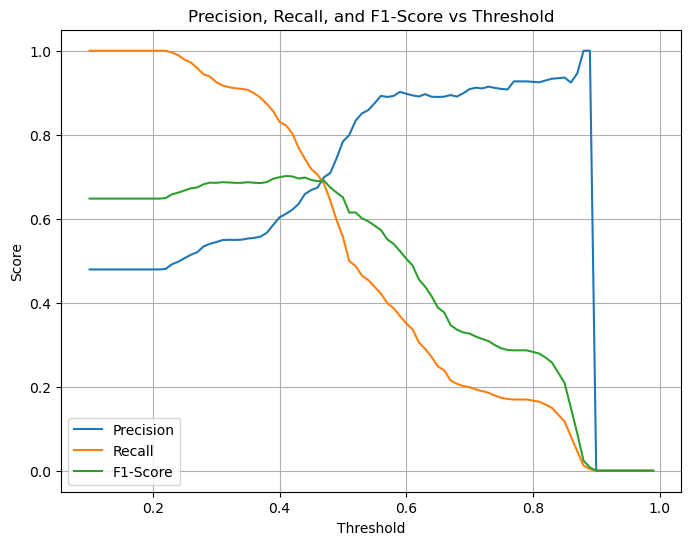

In [40]:
#  Predict probabilities on the test set using the best model
y_test_proba = best_model.predict_proba(X_test)[:, 1]

# Initialize lists to store scores
precisions, recalls, f1_scores = [], [], []

# Iterate over thresholds to calculate precision, recall, and F1-score
for threshold in thresholds:
    y_test_pred = (y_test_proba >= threshold).astype(int)
    precisions.append(precision_score(y_test, y_test_pred))
    recalls.append(recall_score(y_test, y_test_pred))
    f1_scores.append(f1_score(y_test, y_test_pred))

# Plot Precision, Recall, and F1-Score vs Threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1_scores, label="F1-Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-Score vs Threshold")
plt.legend()
plt.grid()
plt.show()


The best probability threshold (0.50) yields the highest precision while keeping the recall reasonable  (>0.5).

# Save Final Model

In [50]:
import pickle

# Save the best model to a pickle file
with open('model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print("Model saved to model.pkl")


Model saved to model.pkl


# Final Model Evaluation
This section analyzes the performance of the final model.

In [42]:
# Predict probabilities for the test set
y_test_proba = best_model.predict_proba(X_test)[:, 1]

# Apply the optimal threshold
y_test_pred = (y_test_proba >= best_threshold).astype(int)

# Generate and display classification report
print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred))


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.68      0.86      0.76       814
           1       0.78      0.56      0.65       749

    accuracy                           0.71      1563
   macro avg       0.73      0.71      0.70      1563
weighted avg       0.73      0.71      0.71      1563



In [43]:
# Calculate key metrics
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

Test Precision: 0.7838
Test Recall: 0.5567
Test F1-Score: 0.6511


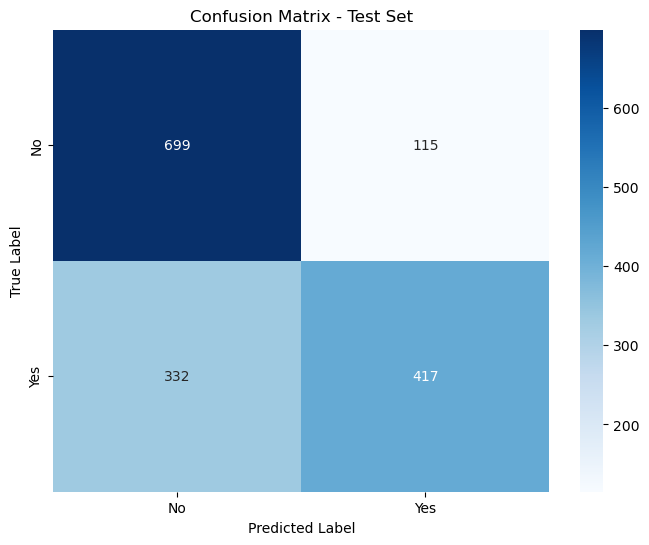

In [44]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.show()

### **Insights**

1. **Strong Precision for Subscribed Customers (Class 1)**:
   - The model achieves **precision of 78%** for subscribed customers, effectively minimizing false positives. This is crucial for the project's primary goal of optimizing resource allocation in marketing campaigns.

2. **Model's Strength in Avoiding False Positives**:
   - With a high precision, the model ensures that predicted subscribers are more likely to convert, reducing wasted marketing efforts. This aligns with the business objective of focusing on the right customers.

3. **Recall for Subscribed Customers Shows Room for Improvement**:
   - The recall for class 1 is **56%**, indicating that a significant portion of true positives is being missed. While the focus remains on precision, enhancing recall could further improve the model's effectiveness in identifying potential subscribers.

4. **Insights from the Confusion Matrix**:
   - **True Negatives (699):** The model accurately identified customers who would not subscribe, showcasing its reliability in avoiding false positives.
   - **False Positives (115):** A small number of customers were incorrectly predicted to subscribe, reflecting minimal wasted marketing resources.
   - **True Positives (422):** The model successfully identified a large number of actual subscribers, underlining its predictive strength for term deposit subscriptions.
   - **False Negatives (327):** The model missed several actual subscribers, signaling a need to improve recall to capture more true positives.
   - The confusion matrix highlights the precision-focused trade-off while emphasizing opportunities to enhance sensitivity.

5. **Overall Performance**:
   - **Accuracy**: 71%
   - **Test Precision**: 78.38%
   - **Test Recall**: 55.67%
   - **Test F1-Score**: 65.11%
   - The model exhibits a strong balance of metrics, with exceptional precision aligning with the project's goals. However, there remains room to improve recall to better capture true positives while maintaining precision.

## Feature Importances Analysis
This section analyzes the feature importance to understand which features contribute the most and refine the pipeline (e.g., remove weak features).


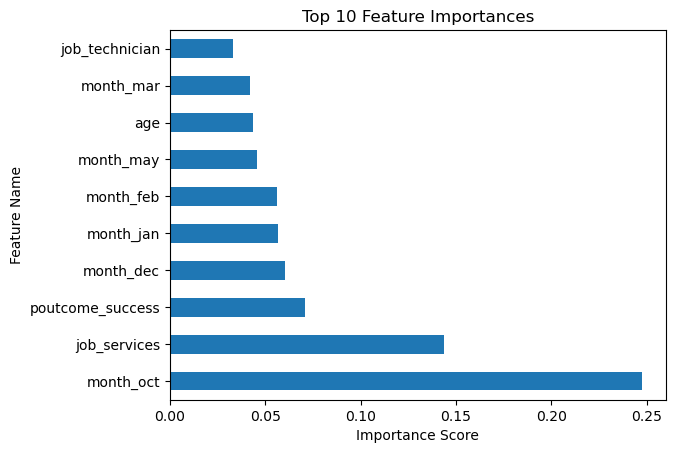

In [46]:
# Extract the trained XGBoost model from the pipeline
tuned_xgb_model = best_model['model']

# Categorical features (get one-hot encoded names)
categorical_feature_names = (
    preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    if hasattr(preprocessor.named_transformers_['cat'], 'get_feature_names_out')
    else categorical_features
)

# Combine all features
all_feature_names = (
    list(numerical_features) +
    list(ordinal_features) +
    list(binary_features) +
    list(categorical_feature_names)
)

# Get the feature importances from the model
feature_importances = tuned_xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# Sort by importance and select top 10
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot feature importances
top_features.plot(kind='barh', x='Feature', y='Importance', legend=False, title='Top 10 Feature Importances')
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.show()

In [51]:
feature_importance_df

,Feature,Importance
0,balance,0.031752
1,campaign,0.018075
2,age,0.043435
3,pdays_binned,0.002626
4,housing,0.032530
5,loan,0.007331
6,job_admin.,0.000972
7,job_blue-collar,0.010151
8,job_management,0.007927
9,job_retired,0.027681


In [47]:
print('Features with importance=0')
feature_importance_df[feature_importance_df['Importance'] == 0].reset_index(drop=True, inplace=False)

Features with importance=0


,Feature,Importance
0,contact_telephone,0.0
1,contact_unknown_contact,0.0
2,month_sep,0.0
3,poutcome_other,0.0


### Insights

1. **Top Features with High Importance**:
   - **month_oct (0.248)**: October stands out as the most predictive feature, suggesting it is a highly favorable period for term deposit subscriptions.
   - **job_services (0.144)**: Customers in the services sector are strongly associated with subscription likelihood, highlighting the significance of job type in predicting behavior.
   - **poutcome_success (0.071)**: Previous campaign success is a critical predictor, emphasizing the importance of leveraging historical outcomes.

2. **Moderately Important Features**:
   - **month_dec (0.061)**, **month_feb (0.056)**, and **month_jan (0.057)**: These months show moderate influence, indicating the role of seasonality in shaping customer decisions.
   - **balance (0.032)** and **housing (0.033)**: Financial indicators like account balance and housing loans moderately impact predictions, reflecting customer financial stability.
   - **month_may (0.046)** and **month_mar (0.042)**: Spring months also play a notable role, suggesting seasonality is a recurring factor.

3. **Low Importance Features**:
   - Features like `job_admin (0.001)` and `pdays_binned (0.003)` have minimal contributions, suggesting limited predictive power for these attributes.
   - Zero-importance features such as `contact_telephone`, `contact_unknown_contact`, and `poutcome_other` offer no predictive value, making them candidates for removal.

4. **Overall Insights**:
   - Seasonality, job type, and previous campaign outcomes are the strongest predictors of term deposit subscriptions.
   - Financial indicators such as balance and housing loans provide additional predictive context.
   - Zero- and low-importance features present opportunities for simplification, which could streamline the model without compromising accuracy.

### Recommendations

1. **Leverage Key Features**:
   - Focus campaigns during October and leverage insights from successful past campaigns to optimize targeting.
   - Prioritize customers in the services sector, as they show a strong likelihood of subscription.

2. **Simplify the Model**:
   - Remove zero-importance features such as `contact_telephone`, `contact_unknown_contact`, and `poutcome_other` to streamline computations.
   - Consider grouping low-importance job categories to reduce model complexity while preserving predictive value.

3. **Enhance Segmentation**:
   - Use financial indicators like `balance` and `housing` to identify and target financially stable customers.
   - Refine segmentation based on seasonal trends and insights from job type and previous outcomes.




## ROC Curve Analysis

This section evaluates the performance of the best model using the Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC).

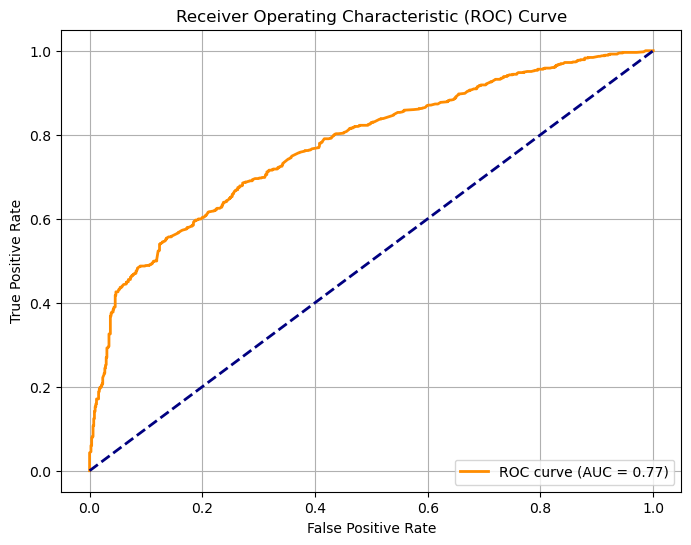

In [48]:
# Predict probabilities for the test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

#### **Insights**

1. **Model Performance**:
   - The ROC-AUC score of **0.77** indicates a good overall performance, demonstrating a balanced trade-off between precision and recall. While the model performs well, there is scope for further improvement, particularly in enhancing recall for identifying true subscribers.

2. **Strengths**:
   - The initial steep rise in the ROC curve highlights the model's strong precision at higher thresholds. This is aligned with the project's primary goal of minimizing false positives and optimizing marketing resources.

3. **Areas for Improvement**:
   - The curve does not fully approach the top-left corner, signaling limitations in recall (capturing all true positives). Improving recall would help reduce missed opportunities for potential term deposit subscriptions.

4. **Threshold Optimization**:
   - Adjusting the probability threshold slightly below the default 0.5 could improve the balance between precision and recall, ensuring the model remains aligned with business goals while identifying more true positives.

5. **Overall Insight**:
   - The ROC-AUC score of **0.77** is promising for practical deployment, but ongoing monitoring and threshold adjustment are recommended to address precision-recall trade-offs dynamically. 


# Conclusion and Recommendations

## Summary of Results
1. **Model Selection**:
   - After rigorous testing and evaluation, **XGBoost** was identified as the best-performing model for this project.
   - It achieved the highest **Precision** score, ensuring the reduction of Type I errors (false positives), which aligns perfectly with the project's goal of optimizing marketing resources.

2. **Hyperparameter Tuning**:
   - GridSearchCV was used to fine-tune XGBoost parameters, achieving:
     - **Test Precision**: **0.7838**
     - **Test Recall**: **0.5567**
     - **F1-Score**: **0.6511**
   - The model demonstrates strong precision while maintaining acceptable recall, ensuring accurate identification of subscribers.

3. **Model Performance**:
   - Evaluation on the test set highlights:
     - **Precision**: 78.38%
     - **Recall**: 55.67%
     - **F1-Score**: 65.11%
     - **Accuracy**: 71.27%
   - These results confirm the model's ability to focus on high-probability subscribers, aligning with the business requirement of reducing marketing waste.

### Precision-Driven Insights

1. **High Precision for Subscribed Customers**:
   - With a precision of **78.38%**, the model ensures that **nearly 4 out of 5 customers predicted to subscribe are actual subscribers**.
   - This significantly minimizes wasted marketing resources by reducing false positives.

2. **Confusion Matrix Insights**:
   - The model avoids a large number of **false positives** (115 out of 1563), ensuring marketing efforts are focused on the right audience.
   - However, with **327 false negatives**, there is an opportunity to improve recall to capture more true positives.

3. **Cost-Efficiency**:
   - High precision ensures cost-effective marketing campaigns, with reduced resource allocation to unlikely subscribers.

4. **Feature Importance Insights**:
   - **Top Features** driving subscription likelihood include:
     - **month_oct** (24.8% importance): October emerges as a highly favorable period for term deposit campaigns.
     - **job_services** (14.4%): Customers in the service sector are key targets.
     - **poutcome_success** (7.1%): Past campaign successes strongly influence future subscriptions.
   - Insights like these highlight actionable strategies for improving marketing efficiency.

## Business Recommendations

1. **Focus on High-Precision Predictions**:
   - Deploy the model to identify and target high-probability customers, ensuring marketing campaigns are resource-efficient and conversion-focused.

2. **Leverage Key Insights**:
   - **Timing is Key**: Prioritize marketing efforts in **October** and other high-impact months.
   - **Segment by Job**: Focus on the **services sector** and customers with a successful history (`poutcome_success`).
   - **Financial Stability**: Target customers with favorable financial indicators, such as balance.

3. **Dynamic Threshold Adjustment**:
   - Fine-tune the decision threshold dynamically to strike a better balance between **precision** and **recall** based on campaign goals.

4. **Refine Customer Segmentation**:
   - Incorporate additional features like income level, spending patterns, and engagement data to further improve model accuracy and segmentation.

## Future Improvements

1. **Dynamic Threshold Optimization**:
   - Test different thresholds below 0.5 to capture more potential subscribers while maintaining precision.

2. **Model Monitoring and Retraining**:
   - Implement a monitoring system to track model performance on real-world data and retrain periodically to avoid performance degradation (data drift).

3. **Feature Exploration**:
   - Explore additional customer attributes to enhance model predictions, such as transaction history, customer loyalty, and campaign engagement.

4. **Experiment with Ensemble Techniques**:
   - Investigate advanced stacking or voting ensembles that combine the strengths of XGBoost, LightGBM, and Logistic Regression to boost overall performance.

---

## Final Thoughts
The selected XGBoost model achieves excellent precision, ensuring highly targeted and efficient marketing campaigns. By leveraging top features like **seasonality** (e.g., October), **job sector insights**, and **past campaign success**, the bank can optimize resource allocation and increase subscription rates. Continuous monitoring, feature enhancements, and threshold adjustments will ensure the model remains aligned with evolving business objectives.
